In [300]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame, get_mesh_from_bm_image
# from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from skimage import io
import pyvista as pv

import ipyvolume as ipv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
# dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
#            'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
# all_df = []
# for name,dirname in dirnames.items():
#     _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
#     _df = _df.drop_duplicates().sort_index().reset_index()
#     _df['Region','Meta'] = name
#     _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
#     _df = _df.set_index(['Frame','TrackID'])
#     all_df.append(_df)

# all_df = pd.concat(all_df)
# all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [301]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

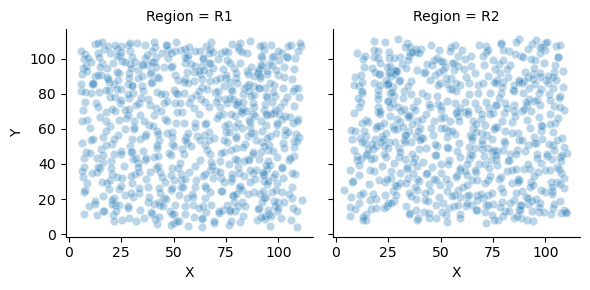

In [207]:
g = sb.FacetGrid(births.droplevel(1,axis=1), col='Region')
g.map(sb.scatterplot,'X','Y',alpha=0.3)
# plt.legend()

# Lineage sizes

In [307]:
all_df['Region'] = [f[0] for f in all_df.index.get_level_values(1).str.split('_',expand=True)]
R1 = all_df[all_df['Region'] == 'R1']
R2 = all_df[all_df['Region'] == 'R2']

# Initial tissue curvature v. clone size visualizations
lineages = {linID:lineage for linID,lineage in all_df.droplevel(axis=1,level=1).groupby(['Region','LineageID'])}
clone_stats = pd.DataFrame(index=lineages.keys(),
                           columns=['Initial tissue curvature','Total lineage size','Final basal cell count'])

for linID, lineage in lineages.items():
    if 0 in lineage.index.get_level_values(0): # Shouldn' fail...
        clone_stats.loc[linID,'Region'] = linID[0]
        clone_stats.loc[linID,'Initial tissue curvature'] = lineage.loc[0,:]['Mean curvature 5um'].values
        clone_stats.loc[linID,'Total lineage size'] = len(lineage.index.get_level_values(1).unique())
        if 14 in lineage.index.get_level_values(0):
            clone_stats.loc[linID,'Final basal cell count'] = sum(lineage.loc[14,:]['Cell type'] == 'Basal')
        else:
            clone_stats.loc[linID,'Final basal cell count'] = 0
        

In [209]:
clone_stats['Total lineage size'].astype(float).isna().sum()

np.int64(92)

v. total size: R = 0.18118765662495462, P = 1.7225797113946752e-06
v. total size: R = 0.17475805989075205, P = 4.006310522197932e-06


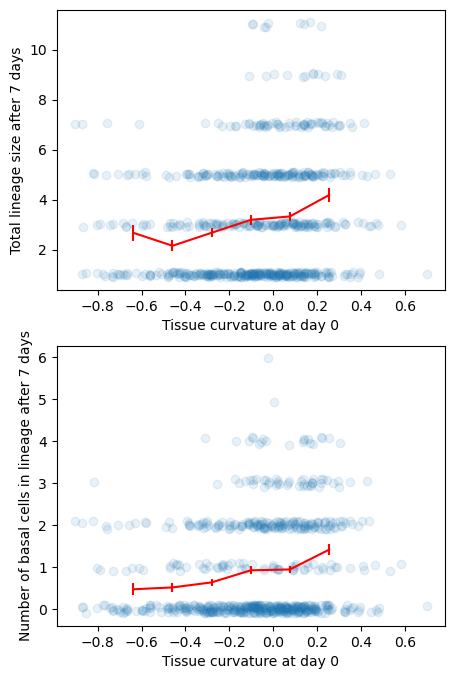

In [308]:
from scipy import stats
from basicUtils import jitter, plot_bin_means, nonan_pairs

plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.scatter(clone_stats['Initial tissue curvature'],
            jitter(clone_stats['Total lineage size'],sigma=.2), alpha=.1)
plt.ylabel('Total lineage size after 7 days')
plt.xlabel('Tissue curvature at day 0')
# plt.yticks([0,1,3,5,7,9,11])
plot_bin_means(clone_stats['Initial tissue curvature'],
               clone_stats['Total lineage size'],
               bin_edges=10,color='r',mean='mean',
               minimum_n=30)
X,Y = nonan_pairs(clone_stats['Initial tissue curvature'].astype(float),clone_stats['Total lineage size'].astype(float))
R,P = stats.pearsonr(X,Y)
print(f'v. total size: R = {R}, P = {P}')

plt.subplot(2,1,2)
plt.scatter(clone_stats['Initial tissue curvature'],
            jitter(clone_stats['Final basal cell count'],sigma=.2), alpha=.1)
plt.ylabel('Number of basal cells in lineage after 7 days')
plt.xlabel('Tissue curvature at day 0')
# plt.yticks([0,1,2,3,4,5,6])
plot_bin_means(clone_stats['Initial tissue curvature'],
               clone_stats['Final basal cell count'],
               bin_edges=10,color='r',mean='mean',
              minimum_n=30)
X,Y = nonan_pairs(clone_stats['Initial tissue curvature'].astype(float),clone_stats['Final basal cell count'].astype(float))
R,P = stats.pearsonr(X,Y)
print(f'v. total size: R = {R}, P = {P}')

model_dir = '/Users/xies/OneDrive - Stanford/Skin/Mesa et al/Lineage models/'
plt.savefig(path.join(model_dir,'Differentiation visualizations/tissue_curvature_v_lineage_size.svg'))

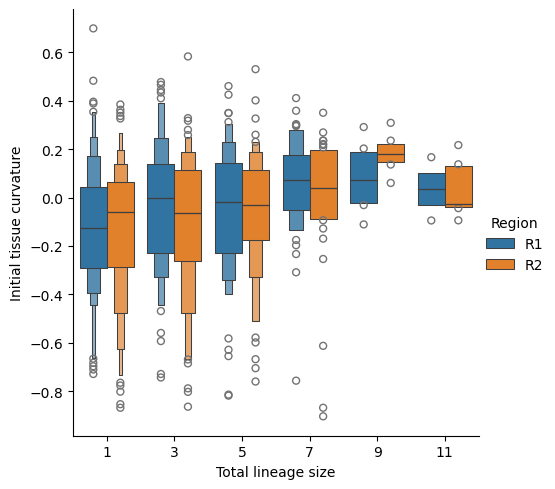

In [212]:
clone_stats['Total lineage size'] = clone_stats['Total lineage size'].astype('category')
clone_stats['Final basal cell count'] = clone_stats['Final basal cell count'].astype('category')
clone_stats['Initial tissue curvature'] = clone_stats['Initial tissue curvature'].astype(float)

sb.catplot(clone_stats,x='Total lineage size',
           y='Initial tissue curvature',hue='Region',
           dodge=True,kind='boxen')


## Spatially plot curvature and point processes

<Axes: xlabel='X', ylabel='Y'>

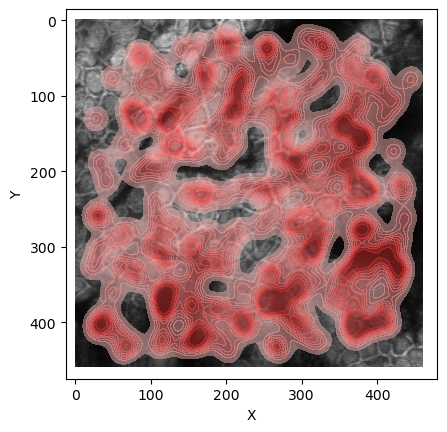

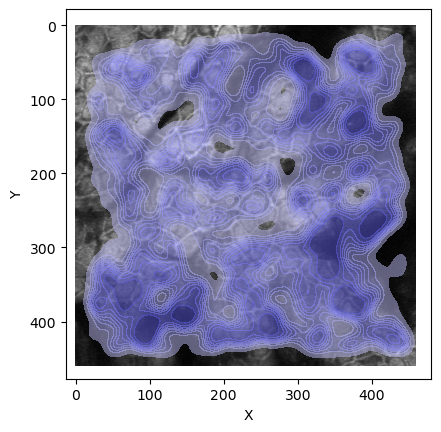

In [32]:
dx = .25
t0 = io.imread(path.join(path.join(dirnames['R1'],'im_seq/t0.tif')))

_diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
_diff = _diff[_diff['Region'] == 'R1']
_diff['X'] /= dx; _diff['Y'] /= dx
# plt.scatter(_df['X']/dx,_df['Y']/dx,color='r',alpha=0.5)
ax = plt.imshow(t0[55,...,1],cmap='gray')
sb.kdeplot(_diff,x='X',y='Y',color='r',bw_method=0.1, fill=True, alpha=0.5)

plt.figure()
_div = births[~births['Will differentiate','Meta']].droplevel(level=1,axis=1)
_div = _div[_div['Region'] == 'R1']
_div['X'] /= dx; _div['Y'] /= dx
ax = plt.imshow(t0[55,...,1],cmap='gray')
sb.kdeplot(_div,x='X',y='Y',color='b',bw_method=0.1, fill=True, alpha=0.5)
# sb.kdeplot(_diff,x='X',y='Y',color='b',bw_method=0.1, fill=False, alpha=0.5)

In [310]:
# Plotting utils

from measurements import get_mesh_from_bm_image, get_tissue_curvature_sparse

def plot_mesh_curvature_kde_overlay(mesh,curv,df,colormap='viridis',color='r',title=None,dx=0.25,dz=1,alpha=0.3):
    X_ = mesh.vertices[:,0]; Y_ = mesh.vertices[:,1]
    
    plt.scatter(X_/dx,Y_/dx,c=curv,cmap = colormap, alpha=0.5)
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == 'R1']
    _diff['X'] /= dx; _diff['Y'] /= dx
    sb.kdeplot(df,x='X',y='Y',color='r',bw_method=0.1, fill=True, alpha=alpha)
    plt.title(title)

def plot_mesh_curvature_scatter_overlay(mesh,curv,df,color='r',title=None,dx=0.25,dz=1, alpha=0.3):
    X_ = mesh.vertices[:,0]; Y_ = mesh.vertices[:,1]
    
    plt.scatter(X_/dx,Y_/dx,c=curv,cmap = 'BrBG')
    plt.colorbar()
    plt.clim([-1.5,1.5])
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == 'R1']
    _diff['X'] /= dx; _diff['Y'] /= dx
    plt.scatter(df['X'],df['Y'],color='r',alpha=.6)
    plt.title(title)
    

0


NameError: name 't0' is not defined

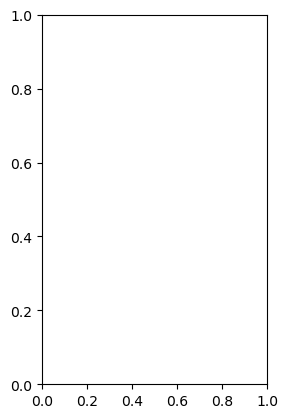

In [311]:
regions = ['R1','R2']

kappa=7
dx=0.25;dz=1
t= 0

for i,region in enumerate(regions):
    print(i)
    plt.subplot(1,2,i+1)
    bm_img = io.imread(path.join(dirnames[region],f'Image flattening/height_image/t{t}.tif'))
    mesh = get_mesh_from_bm_image(bm_img)
    mean_curve,_ = get_tissue_curvature_sparse(mesh,kappa=kappa)
    _div = births[~births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _div = _div[_div['Region'] == region]
    _div['X'] /= dx; _div['Y'] /= dx
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == region]
    _diff['X'] /= dx; _diff['Y'] /= dx
    
    ax = plt.imshow(t0[55,...,1])
    ax = plt.scatter(mesh.vertices[:,0]/.25,mesh.vertices[:,1]/.25,c=mean_curve,cmap='BrBG',alpha=0.2)
    plt.colorbar()
    

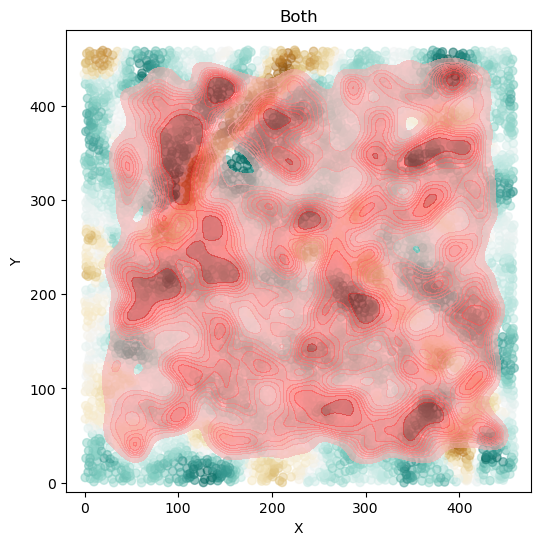

In [42]:
fig=plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

# plot_mesh_curvature_kde_overlay(mesh, mean_curve, _div,color='r',title='Diff',colormap='BrBG',alpha=.6)
# plot_mesh_curvature_kde_overlay(mesh, mean_curve, _div,color='r',title='Div',colormap='BrBG',alpha=.6)
plot_mesh_curvature_kde_overlay(mesh, mean_curve, pd.concat((_diff,_div)),color='r',title='Both',colormap='BrBG',alpha=.6)


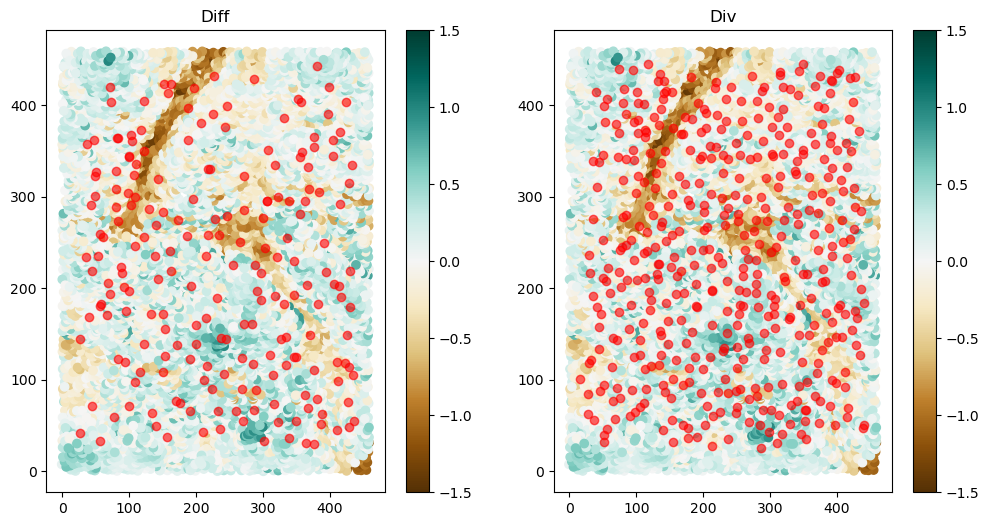

In [15]:

fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plot_mesh_curvature_scatter_overlay(mesh, mean_curve, _diff ,color='r',title='Diff', alpha=0.2)
plt.subplot(1,2,2)
plot_mesh_curvature_scatter_overlay(mesh,mean_curve, _div,color='r',title='Div')


# Different kappas

In [5]:
# Recalculate mean curvature w different kappas

result = []
for kappa in tqdm(range(2,20)):
    for region,dirname in dirnames.items():
        for t in range(13):
            _df = pd.DataFrame()
            this_region_frame = divisions.loc[t,:].droplevel(axis=1,level=1)
            this_region_frame = this_region_frame[this_region_frame['Region'] == region]
            this_region_frame = this_region_frame[~this_region_frame['Border'].astype(bool)]
            this_region_frame = this_region_frame.dropna(subset=['X','Y','Z','At least one daughter differentiated'])
            if len(this_region_frame) < 1:
                continue
            coords_3d_um = this_region_frame[['X','Y','Z']].values

            bm_img = io.imread(path.join(dirnames[region],f'Image flattening/height_image/t{t}.tif'))
            mesh = get_mesh_from_bm_image(bm_img)
            query_points = mesh.nearest.on_surface(coords_3d_um)[0]
            mean_curv,_ = get_tissue_curvatures(mesh,kappa,query_pts=query_points)

            _df['>1 diff daughter'] = this_region_frame['At least one daughter differentiated']
            _df['# daughter diff'] = this_region_frame['Num daughter differentiated']
            _df['Mean curvature'] = mean_curv
            _df['Kappa'] = kappa
            _df['Region'] = region
            _df['Frame'] = t
            _df['Dividing'] = True

            _df_rand = pd.DataFrame()
            random_non_dividing_cell = all_df.loc[t,:].droplevel(axis=1,level=1)
            random_non_dividing_cell = random_non_dividing_cell[~random_non_dividing_cell['Divide next frame']]
            random_non_dividing_cell = random_non_dividing_cell.dropna(subset=['X','Y','Z'])
            random_non_dividing_cell = random_non_dividing_cell.sample(len(query_points))
            coords_3d_um = random_non_dividing_cell[['X','Y','Z']].values

            query_points = mesh.nearest.on_surface(coords_3d_um)[0]
            mean_curv,_ = get_tissue_curvatures(mesh,kappa,query_pts=query_points)

            _df_rand['Mean curvature'] = mean_curv
            _df_rand['Kappa'] = kappa
            _df_rand['Region'] = region
            _df_rand['Frame'] = t
            _df_rand['>1 diff daughter'] = 0
            _df_rand['# daughter diff'] = 0
            _df_rand['Dividing'] = False
            
            result.append(_df)
            result.append(_df_rand)              

result = pd.concat(result,ignore_index=True)

  0%|                                                     | 0/18 [00:00<?, ?it/s]


NameError: name 'get_tissue_curvatures' is not defined

In [19]:
result['Abs curvature'] = result['Mean curvature'].abs()

result
g = sb.FacetGrid(data=result,row='Dividing')
g.map_dataframe(sb.lineplot,x='Kappa',y='Mean curvature',hue='>1 diff daughter',
               errorbar=('ci'))
plt.legend()

model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models'
plt.savefig(path.join(model_dir,'Differentiation visualizations/tissue_curvature_v_division_fate.svg'))

# result[result.Dividing]

TypeError: list indices must be integers or slices, not str

# cat plots

array([       nan, 0.0094219 , 0.00891259, 0.0096522 , 0.01052753])

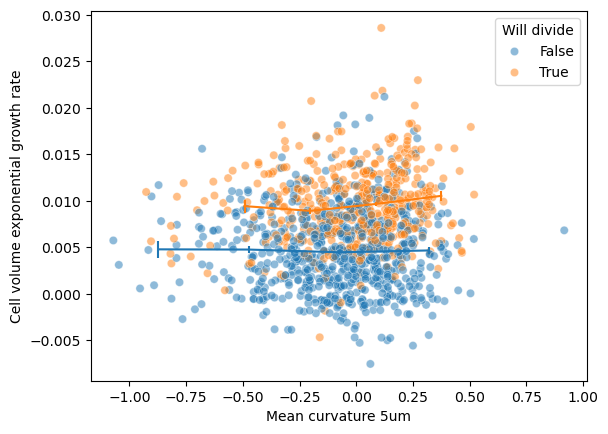

In [298]:
from basicUtils import plot_bin_means

x = 'Mean curvature 5um'
y = 'Cell volume exponential growth rate'
_df = pd.DataFrame.from_dict({trackID:t.droplevel(axis=1,level=1).iloc[0][[x,y,'Will divide']]
                for trackID, t in all_tracks.items()}).T

# sb.scatterplot(all_df.droplevel(axis=1,level=1),x=x,y=y,hue='Will divide',alpha=0.5)
sb.scatterplot(_df,x=x,y=y,hue='Will divide',alpha=0.5)
plot_bin_means(_df[_df['Will divide'] == False][x],_df[_df['Will divide'] == False][y],
               bin_edges = 6, minimum_n=10, mean='mean')
plot_bin_means(_df[_df['Will divide'] == True][x],_df[_df['Will divide'] == True][y],
               bin_edges= 6, minimum_n=20, mean='mean')


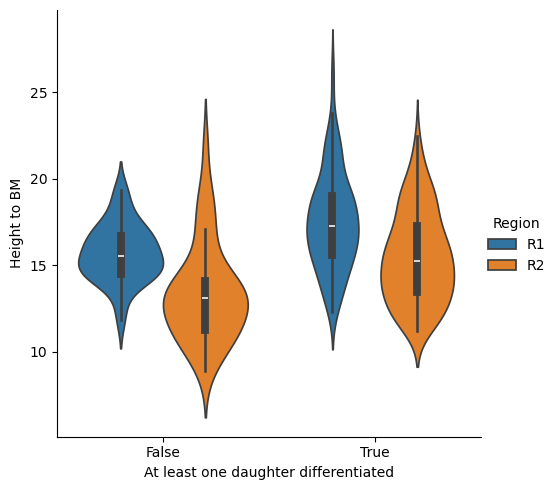

In [87]:

sb.catplot(divisions.droplevel(1,axis=1),x='At least one daughter differentiated',y='Height to BM',
           kind='violin', hue='Region')
# plt.hlines(y=0,xmin=-1,xmax=3)
# divisions[['Region','Num daughter differentiated']]

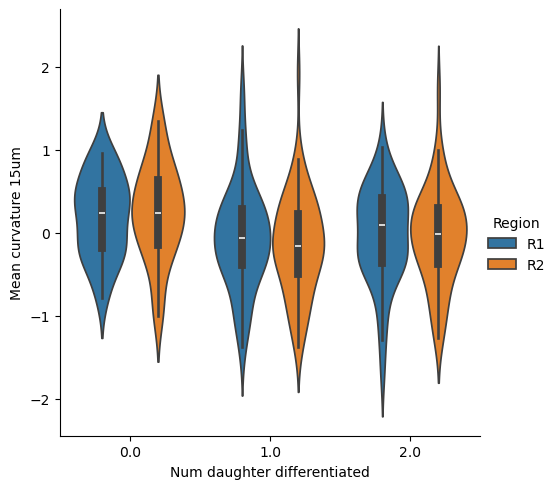

In [82]:

sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature 15um',
           kind='violin', hue='Region')
# plt.hlines(y=0,xmin=-1,xmax=3)
# divisions[['Region','Num daughter differentiated']]

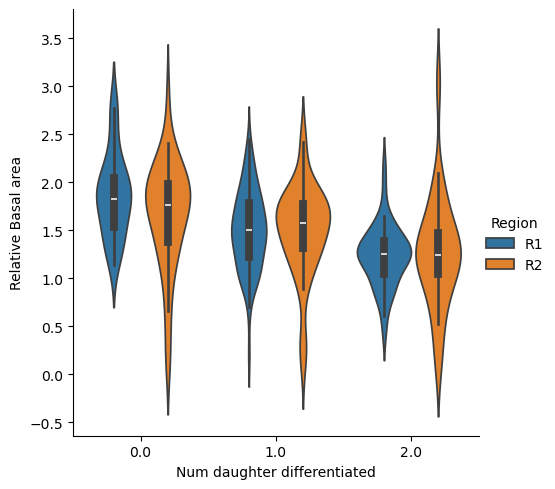

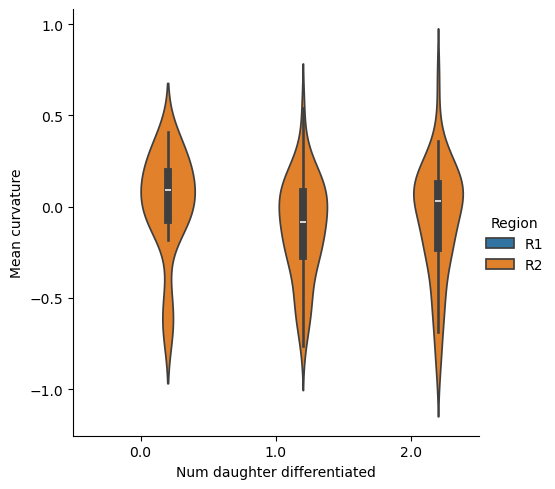

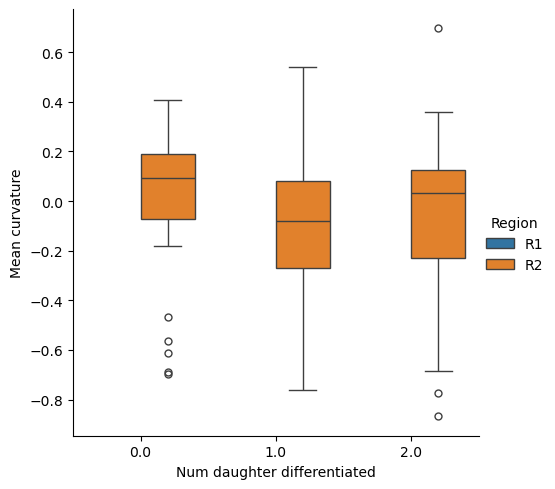

In [53]:

sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Relative Basal area',hue='Region',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature 2um',hue='Region',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature 5um',hue='Region',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature 1-um',hue='Region',kind='violin',dodge=True)


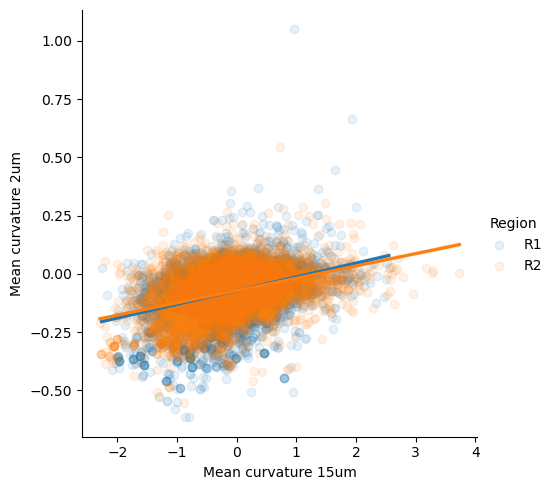

In [98]:
sb.lmplot(all_df.droplevel(1,axis=1),x='Mean curvature 15um',y='Mean curvature 2um',
          hue='Region',scatter_kws={'alpha':.1})

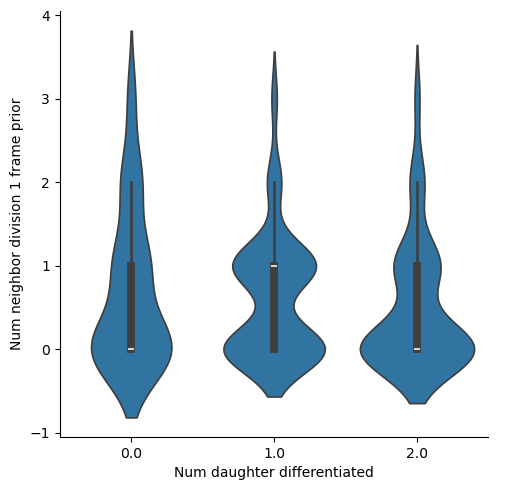

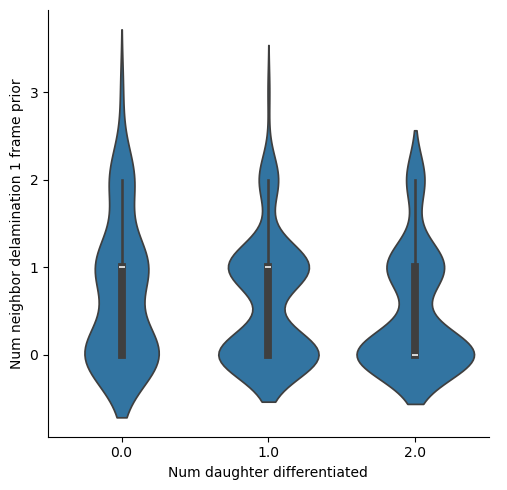

In [89]:
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Num neighbor division 1 frame prior',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Num neighbor delamination 1 frame prior',kind='violin')

# Raw distance to event

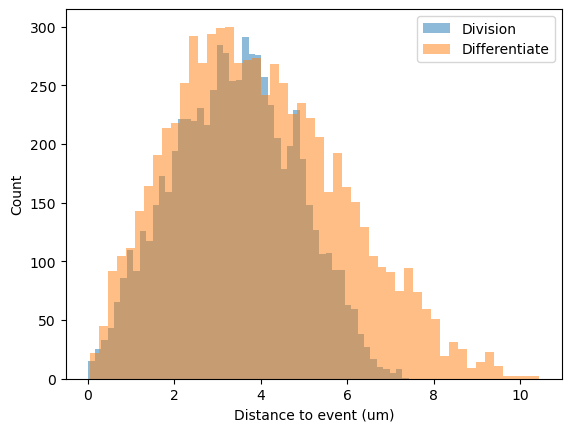

In [320]:
from scipy.spatial import distance

Y = mesh.vertices[:,1]
X = mesh.vertices[:,2]

# mean_curve

basals = all_df[(all_df['Cell type','Meta'] == 'Basal') & (all_df['Region'] == 'R1')]
fate_known = basals[basals['Fate known','Meta']]
fate_known = basals.loc[0,:]
# fate_known
Y_cell = fate_known['X','Measurement']
X_cell = fate_known['Y','Measurement']
fate = fate_known['Will divide','Meta']

D = distance.cdist(np.stack([Y,X]).T,np.stack([Y_cell,X_cell]).T)
# D.shape
min_distance_todiv = D[:,fate].min(axis=1)
plt.hist(min_distance_todiv,50,alpha=0.5)

min_distance_todiff = D[:,~fate].min(axis=1)
plt.hist(min_distance_todiff,50,alpha=0.5)

# min_distance_toany = D.min(axis=1)
# plt.hist(min_distance_toany,50,alpha=0.5)

plt.xlabel('Distance to event (um)')
plt.ylabel('Count')
plt.legend(['Division','Differentiate','Any'])

array([       nan, 4.70216813, 3.9674341 , 3.96081214, 3.72108445,
       3.47199552, 4.07967588, 4.86263172,        nan])

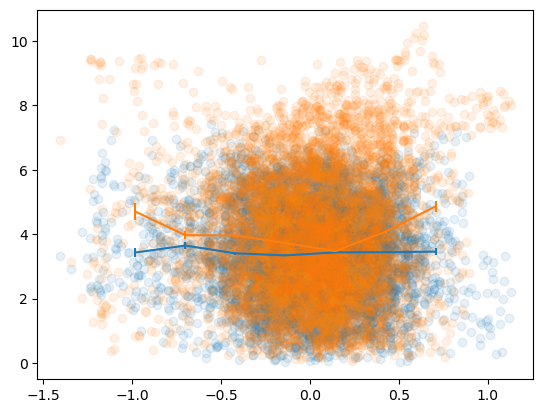

In [321]:
plt.scatter(mean_curve,min_distance_todiv,alpha=0.1)
plot_bin_means(mean_curve,min_distance_todiv,bin_edges=10,minimum_n=50)

plt.scatter(mean_curve,min_distance_todiff,alpha=0.1)
plot_bin_means(mean_curve,min_distance_todiff,bin_edges=10,minimum_n=50)

array([       nan, 2.39342753, 2.5966876 , 2.65430717, 2.43560732,
       2.49998112, 2.56019649, 2.6043195 , 2.22690502])

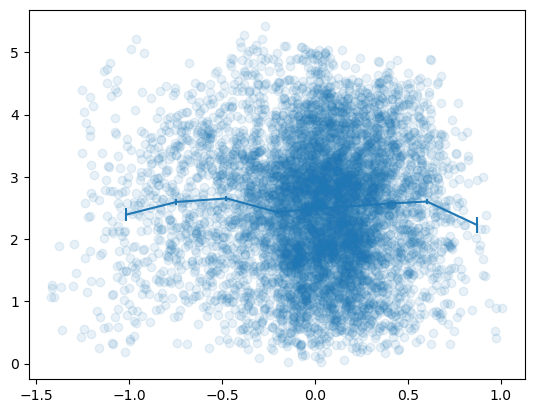

In [57]:
plt.scatter(mean_curve,min_distance_toany,alpha=0.1)
plot_bin_means(mean_curve,min_distance_toany,bin_edges=10,minimum_n=50)


In [109]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(divide_cyto_mesh))
pl.show()

Widget(value='<iframe src="http://localhost:54576/index.html?ui=P_0xcafc69850_13&reconnect=auto" class="pyvist…

In [110]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(diff_cyto_mesh))
pl.show()

Widget(value='<iframe src="http://localhost:54576/index.html?ui=P_0xd18c242b0_14&reconnect=auto" class="pyvist…

# Label dilutions

2323

In [255]:
_df = pd.DataFrame([{trackID:t['Mean curvature 5um','Measurement'].mean() for trackID,t in all_tracks.items()},
                    {trackID:t['Basal area','Measurement'].mean() for trackID,t in all_tracks.items()},
                    {trackID:t['Middle area','Measurement'].mean() for trackID,t in all_tracks.items()},
          {trackID:t['Cell volume exponential growth rate','Measurement'].mean() for trackID,t in all_tracks.items()}]).T

_df = _df.rename(columns={0:'Curve',1:'Basal',2:'Middle',3:'Growth rate'})

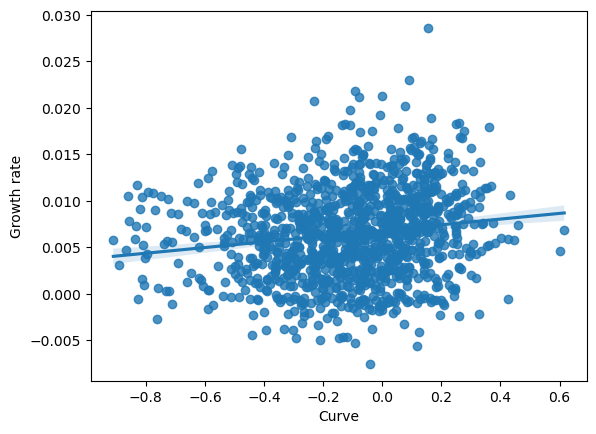

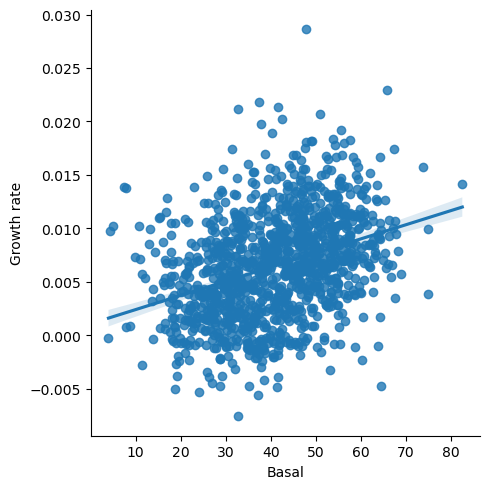

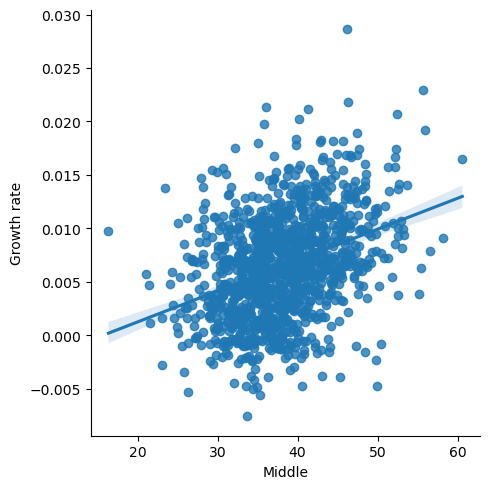

In [252]:
sb.regplot(_df,x='Curve',y='Growth rate')
sb.lmplot(_df,x='Basal',y='Growth rate')
sb.lmplot(_df,x='Middle',y='Growth rate')

In [154]:
# Dictionary of lineages
lineages = {name[0] + '_' + str(int(name[1])):lineage
            for name,lineage in all_df.droplevel(axis=1,level=1).groupby(['Region','LineageID'])}

# Find all basal cells at the last frame
last_frame_basals = basals.droplevel(axis=1,level=1).loc[14,:]
# last_frame_basals['LineageRegionID'] = last_frame_basals['Region'] + '_' + 
# Check that the lineage has a root
for trackID,cell in last_frame_basals.iterrows():
    this_lineage = lineages[ cell['Region'] + '_' + str(int(cell['LineageID'])) ]
    last_frame_basals.loc[trackID,'Rooted'] = 0 in this_lineage.index.get_level_values('Frame')
    
rooted_last_basals = last_frame_basals[last_frame_basals['Rooted']]

results = pd.DataFrame(index=rooted_last_basals.index,columns=['Region','Final curvature','Generation'])

# Go back from each basal cell and find how many generations its inheritance is from a cell in 
for trackID,cell in tqdm(last_frame_basals.iterrows()):
    this_lineage = lineages[ cell['Region'] + '_' + str(int(cell['LineageID'])) ]
    generation = 0
    mother = cell['Mother']
    while not np.isnan(mother):
        mother = all_df.swaplevel(axis=0).loc[cell['Region'] + '_' + str(int(mother)),:].iloc[0]['Mother','Meta']
        generation += 1
    results.loc[trackID,'Generation'] = generation
    results.loc[trackID,'Final curvature'] = cell['Mean curvature 5um']
    results.loc[trackID,'Region'] = cell['Region']

557it [01:07,  8.31it/s]


In [222]:
np.array([1,2,3,4,5,6,7])*24

array([ 24,  48,  72,  96, 120, 144, 168])

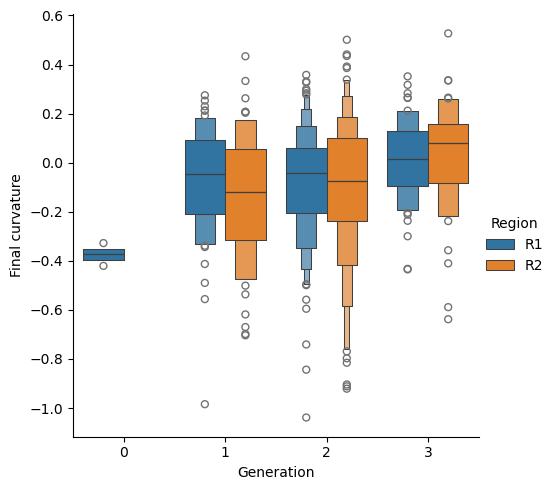

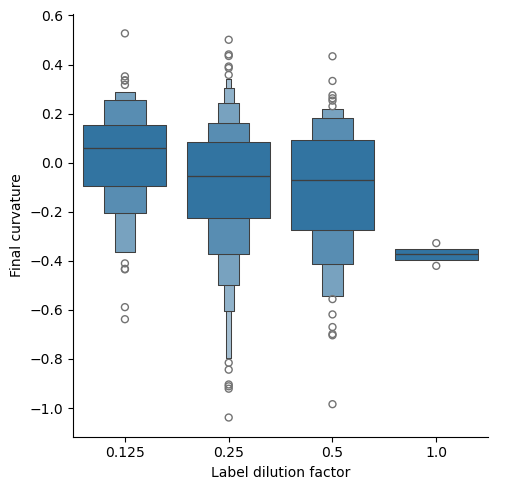

In [229]:
results['Label dilution factor'] = 1/2**(results['Generation'])

# sb.catplot(results,x='Label retention factor',y='Final curvature',kind='swarm',hue='Region',split=True)
fig = sb.catplot(results,x='Generation',y='Final curvature',kind='boxen',hue='Region')
plt.savefig(path.join(model_dir,'Differentiation visualizations/tissue_curvature_v_final_generation.svg'))

sb.catplot(results,x='Label dilution factor',y='Final curvature',kind='boxen')
plt.savefig(path.join(model_dir,'Differentiation visualizations/tissue_curvature_v_label_dilution.svg'))

<Axes: xlabel='Final curvature', ylabel='Label dilution factor'>

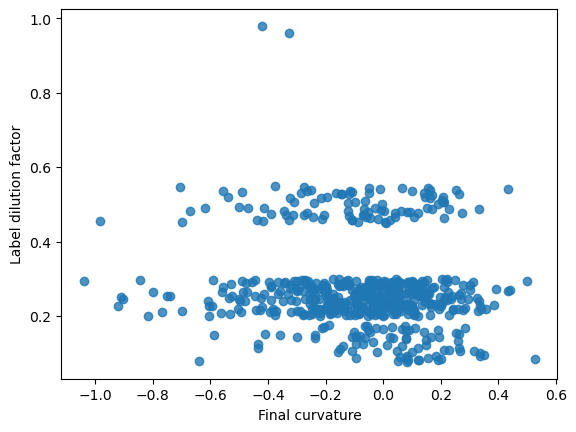

In [219]:
sb.regplot(results,y='Label dilution factor',x='Final curvature',y_jitter=0.05,fit_reg=False)


In [203]:
val

TrackID
R1_13       0.5
R1_17      0.25
R1_21      0.25
R1_22      0.25
R1_31       1.0
           ... 
R1_1087    0.25
R1_1096    0.25
R1_1098     0.5
R1_1137     0.5
R1_1158     0.5
Name: Label dilution factor, Length: 292, dtype: object

In [312]:
from imageUtils import colorize_segmentation
from skimage import util

segmentations = io.imread('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R2/Mastodon/tracked_nuc.tif')[0,...]
keys = np.unique(segmentations)[1:]
label_dilution = colorize_segmentation( segmentations, {k:1 for k,v in zip(keys,val)}, dtype=float)
io.imsave('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R2/Misc/label_dilution_initial.tif',
          util.img_as_uint(label_dilution))

segmentations = io.imread('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R2/Mastodon/tracked_nuc.tif')[14,...]
keys = np.stack(results[results['Region'] == 'R2'].index.str.split('_',expand=True))[:,1].astype(int)
val = results[results['Region'] == 'R2']['Label dilution factor']
label_dilution = colorize_segmentation( segmentations, {k:v for k,v in zip(keys,val)}, dtype=float)
io.imsave('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R2/Misc/label_dilution_final.tif',
          util.img_as_uint(label_dilution))

100%|█████████████████████████████████████████| 265/265 [00:01<00:00, 235.42it/s]


(70, 460, 460)

# Div/diff balance

In [388]:
local_balance['Div'].mean()

Time offset
1       0.615
2      0.8125
3    0.623047
4         NaN
dtype: object

In [426]:
# Div/diff balance calculation

def get_local_balance(centers,region):
    div_TXY = region.droplevel(axis=1,level=1)[region.droplevel(axis=1,level=1)['Divide next frame']].reset_index()[['Frame','X','Y']]
    div_TXY = div_TXY.reset_index().set_index(['Frame','index'])
    diff_TXY = region.droplevel(axis=1,level=1)[region.droplevel(axis=1,level=1)['Delaminate next frame']].reset_index()[['Frame','X','Y']]
    diff_TXY = diff_TXY.reset_index().set_index(['Frame','index'])

    local_turnover = pd.DataFrame(index=divisions.index,columns=pd.MultiIndex.from_product([['Div','Diff'],[1,2,3,4,5]],names=['Behavior','Time offset']))
    local_turnover = local_turnover.fillna(0)

    for (t,trackID),cell in centers.iterrows():
        for offset in [1,2,3,4,5]:
            if t-offset in div_TXY.index.levels[0]:
                this_frame_div = div_TXY.loc[t-offset,:]
                local_turnover.loc[(t,trackID),('Div',offset)] = count_cells_within_distance(cell[['X','Y']], this_frame_div)
            if t-offset in diff_TXY.index.levels[0]:
                this_frame_div = diff_TXY.loc[t-offset,:]
                local_turnover.loc[(t,trackID),('Diff',offset)] = count_cells_within_distance(cell[['X','Y']], this_frame_div)
                
    local_balance = local_turnover['Div'] - local_turnover['Diff']
    return local_balance

def count_cells_within_distance(cell, other_cells, threshold=10):
    # print( (other_cells['X'] - cell['X'])**2 + (other_cells['Y'] - cell['X'])**2 )
    D = np.sqrt((other_cells['X'] - cell['X'])**2 + (other_cells['Y'] - cell['X'])**2)
    return (D < threshold).sum()

# Get coordinates for single div or diff events
local_balance_R1 = get_local_balance(divisions[divisions['Region'] == 'R1'].droplevel(axis=1,level=1),R1)
local_balance_R2 = get_local_balance(divisions[divisions['Region'] == 'R2'].droplevel(axis=1,level=1),R2)


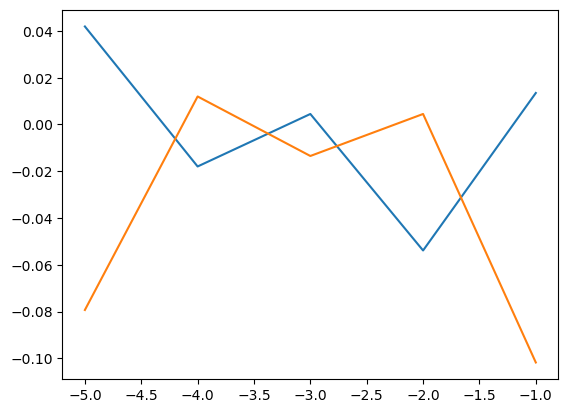

In [425]:
plt.plot([-5,-4,-3,-2,-1],local_balance_R1.mean())
plt.plot([-5,-4,-3,-2,-1],local_balance_R2.mean())

In [369]:
np

<module 'numpy' from '/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/__init__.py'>